# Machine Learning II
## Urban Sound Classification: Deep Learning Approaches for Audio Recognition
#### Work assembled by Aligga Goncigga, Francigga Niggalache, Alexigga Luskigga

### Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data-understanding)
3. [Data Reading](#data-reading)
    - 3.1. [Feature Extraction](#feature-extraction)
    - 3.2. [Data Cleaning](#data-cleaning)
      
      - 3.2.1. [Reading](#reading)
      
      - 3.2.2. [Cleaning](#cleaning)
5. [Classifiers](#classifiers)

   - 4.1. [Multilayer Perceptron (MLP)](#multilayer)
   - 4.2. [convolutional neural network (CNN)](#convolutional)
   
   
  

## Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The objective of this project is to develop **deep learning classifiers** for urban sound data. In this assignment, we will implement two of the three classifiers provided by the professor, as outlined in the [[PDF]](./Project.pdf). 

The classifiers are:

• A classifier based on a multilayer perceptron (MLP)

• A classifier based on a convolutional neural network (CNN)

• A classifier based on a recurrent neural network (RNN)

And for each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation

## Data Understanding <a name="data-understanding"></a>
[[go back to the top]](#contents)


The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- air_conditioner [0] 
- car_horn [1] 
- children_playing [2] 
- dog_bark [3] 
- drilling [4] 
- enginge_idling [5] 
- gun_shot [6] 
- jackhammer [7] 
- siren [8] 
- street_music [9] 

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

![Descrição da imagem](./taxonomy.png)

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| class              | The class name corresponding to the classID (e.g., air_conditioner, car_horn, etc.).                 |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


**To avoid common pitfalls**:
-  Don't reshuffle the data! Use the predefined 10 folds and perform 10-fold (not 5-fold) cross validation
-  Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores

## Data Reading <a name="data-reading"></a>
[[go back to the top]](#contents)


After carefully analyzing the three available classifiers, we decided to implement MLP and CNN for this project. Our decision was based on several important considerations, which we have outlined in detail in the following [[Notes]](./Notas.md).

Let's explore what we have and outline what we'll be working on in the coming days.



#### Imports

In [33]:
import pandas as pd
import librosa
import os
import numpy as np
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import MinMaxScaler

In [4]:
path_csv = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/metadata/UrbanSound8K.csv'

df = pd.read_csv(path_csv)

print(df.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


##### Check if there's any missing values

In [5]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


##### Visualizing graphically

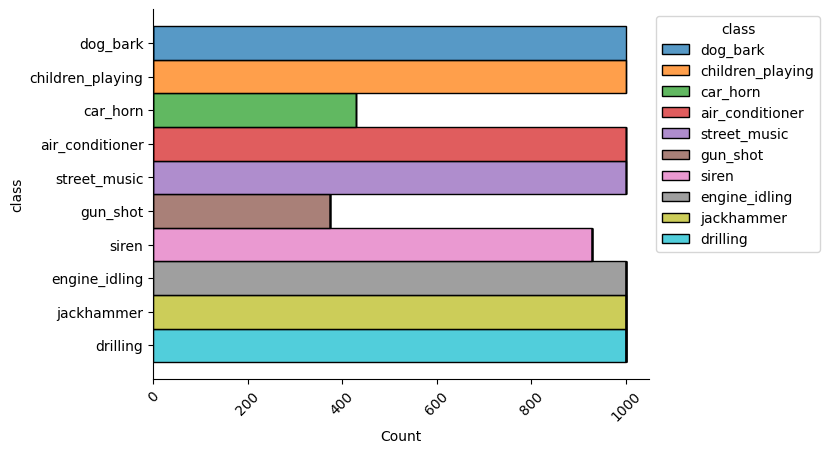

In [6]:
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45);
sns.despine()
plt.show()

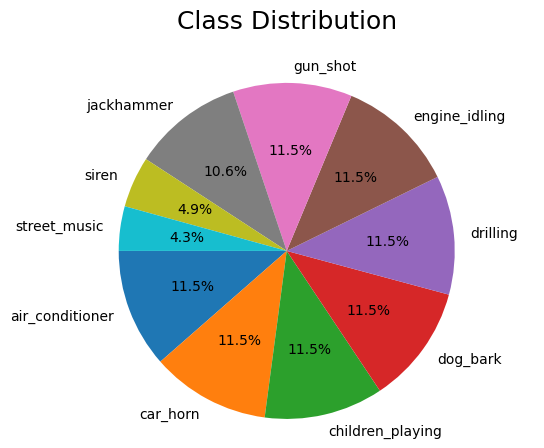

In [5]:
class_dict = df['class'].value_counts(normalize=True)
classes = list(np.unique(df['class']))
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(class_dict, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.savefig("distribution_class")
plt.show(block=False)

##### Accessing the audio data

In [6]:
# Path to the folder where the audio dubs are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Go through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Browse the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Upload audio using librosa
                audio, sample_rate = librosa.load(file_path)
                
                # Example: Process audio or extract features
                print(f"File: {file_name}, Sample Rate: {sample_rate}, Duration: {len(audio)/sample_rate:.2f}s")


File: 101415-3-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-8.wav, Sample Rate: 22050, Duration: 4.00s
File: 102106-3-0-0.wav, Sample Rate: 22050, Duration: 1.64s
File: 102305-6-0-0.wav, Sample Rate: 22050, Duration: 2.61s
File: 102842-3-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-5.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-4.wav, Sample Rate: 220

##### As observed, some audio clips have varying durations, such as 1.64, 2.61, and up to 4 seconds. To simplify the processing and ensure consistency, we will standardize all audio data to the same length. This allows for uniform input to our models, improving training efficiency and performance. How can we do that?

##### Well, there's four strategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.

Although we already thought and started with an approach (Zeropadding), we had a conversation with the teacher about what would be the best strategy to perform, and we came with the conclusion that **Audio Repetition** would be the best.


##### Audio Repetition

In [7]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio is shorter than the target duration
                if len(audio) < target_duration * sample_rate:
                    # Calculate the number of samples required
                    target_samples = int(target_duration * sample_rate)
                    audio_repeated = np.tile(audio, int(np.ceil(target_samples / len(audio))))
                    audio_repeated = audio_repeated[:target_samples]
                else:
                    audio_repeated = audio
                
                # Save the adjusted audio, replacing the original (or in a new directory)
                sf.write(file_path, audio_repeated, sample_rate)
                print(f"File {file_name} processed with duration of {target_duration} seconds.")


Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold1...
File 101415-3-0-2.wav processed with duration of 4.0 seconds.
File 101415-3-0-3.wav processed with duration of 4.0 seconds.
File 101415-3-0-8.wav processed with duration of 4.0 seconds.
File 102106-3-0-0.wav processed with duration of 4.0 seconds.
File 102305-6-0-0.wav processed with duration of 4.0 seconds.
File 102842-3-0-1.wav processed with duration of 4.0 seconds.
File 102842-3-1-0.wav processed with duration of 4.0 seconds.
File 102842-3-1-5.wav processed with duration of 4.0 seconds.
File 102842-3-1-6.wav processed with duration of 4.0 seconds.
File 103074-7-0-0.wav processed with duration of 4.0 seconds.
File 103074-7-0-1.wav processed with duration of 4.0 seconds.
File 103074-7-0-2.wav processed with duration of 4.0 seconds.
File 103074-7-1-0.wav processed with duration of 4.0 seconds.
File 103074-7-1-1.wav processed with duration of 4.0 seconds.
File 103074-7-1-2.wav processed wit

##### Checking if there's still audios with duration different than 4 seconds

In [8]:
# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8725
Audio files with a duration different from 4 seconds:
36429-2-0-13.wav - Duration: 4.04 seconds
36429-2-0-14.wav - Duration: 4.04 seconds
36429-2-0-15.wav - Duration: 4.04 seconds
36429-2-0-18.wav - Duration: 4.04 seconds
36429-2-0-23.wav - Duration: 4.04 seconds
36429-2-0-6.wav - Duration: 4.04 seconds
36429-2-0-7.wav - Duration: 4.04 seconds


##### Okay, we still have files with more than 4 seconds. For that we have a strategy called Trimming.

In [9]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio duration is greater than 4 seconds
                if len(audio) > target_duration * sample_rate:
                    # Trim audio to exactly 4 seconds
                    audio = audio[:int(target_duration * sample_rate)]
                    print(f"Trimming {file_name} to {target_duration} seconds.")
                    
                    # Save the trimmed audio, replacing the original file
                    sf.write(file_path, audio, sample_rate)



Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold1...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold2...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold3...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold4...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold5...
Trimming 19007-4-0-0.wav to 4.0 seconds.

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold6...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold7...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold8...
Trimming 36429-2-0-13.wav to 4.0 seconds.
Trimming 36429-2-0-14.wav to 4.0 seconds.
Trimming 36429-2-0-15.wav to 4.0 seconds.
Trimming 36429-2-0-18.wav to 4.0 seconds.
Trimming 36429-

##### Let's see now if all the files have 4 seconds.

In [10]:
# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8732
All audio files are 4 seconds long.


##### Great! Now, let's begin the feature extraction.

## Feature Extraction <a name="feature-extraction"></a>
[[go back to the top]](#contents)

As described in [[Notes]](./Notas.md) and in [[PDF]](./Project.pdf), we will need to extract features, and for that we'll use **Mel-Frequency Cepstral Coefficients (MFCCs)** which are well known for their success in environmental sound classification.

We will create a csv to save those features. The provided code returns a set of CSV files, one for each folder (fold) in the dataset, structured as follows:
- Features: Numerical values of extracted features, including:
    - Spectral features (e.g., chroma_stft, rms, centroid, bandwidth, rolloff).
    - Rhythmic features (e.g., tempogram, fourier_tempogram).
    - Mel-Frequency Cepstral Coefficients (MFCCs 1–40).
    - Label: The filename of the audio file for identification.

In [11]:
# Function to extract features from a given audio file
def extract_features(audio_file, target_duration=4, target_sr=44100):

    # Load audio and define target sample rate
    y, sr = librosa.load(audio_file, sr=target_sr)

    # Ensure audio length is the same as the target duration using zero padding
    target_length = int(target_sr * target_duration)
    y = librosa.util.fix_length(y, size=target_length)

    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Define variables for some features
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # spectral feature list
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    rms = librosa.feature.rms(y=y)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    crossing_rate = librosa.feature.zero_crossing_rate(y)

    # rhythm feature list
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

    # Create a dictionary to store the mean value of the features
    features = {
        'chroma_stft': np.mean(chroma_stft),
        'chroma_cqt': np.mean(chroma_cqt),
        'chroma_cens': np.mean(chroma_cens),
        'melspectogram': np.mean(melspectogram),
        'rms': np.mean(rms),
        'centroid': np.mean(centroid),
        'bandwidth': np.mean(bandwidth),
        'contrast': np.mean(contrast),
        'flatness': np.mean(flatness),
        'rolloff': np.mean(rolloff),
        'crossing_rate': np.mean(crossing_rate),
        'tempogram': np.mean(tempogram),
        'fourier_tempogram': np.mean(fourier_tempogram)
    }

    # Add the mean of each MFCC feature to the dictionary
    for i in range(1, 41):
        features[f'mcffs_{i}'] = np.mean(mfccs[i - 1])
    return features


# Function to iterate through each audio folder and extract features from each file
def process_data(base_dir):
    for folder in os.listdir(base_dir):
        label_list = []
        features_list = []
        fold_dir = os.path.join(base_dir, folder)
        if os.path.isdir(fold_dir):
            for filename in os.listdir(fold_dir):
                file_path = os.path.join(fold_dir, filename)
                if filename.endswith('.wav'):
                    label = filename
                    features = extract_features(file_path)
                    features_list.append(features)
                    label_list.append(label)

        # Create DataFrame for each folder
        df = pd.DataFrame(features_list)
        df['Label'] = label_list
        # Save DataFrame as a CSV file
        df.to_csv('urbansounds_features' + folder + '.csv', index=False)
        # Display the DataFrame
        print(df.head())


def main():
    base_dir = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'
    process_data(base_dir)


if __name__ == '__main__':
    main()

Empty DataFrame
Columns: [Label]
Index: []


C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.494283    0.559240     0.266609       3.462753  0.068631  1258.207615   
1     0.422105    0.562016     0.271383       3.130538  0.076677  1077.123550   
2     0.575468    0.607640     0.276090       2.266523  0.044331  1451.517441   
3     0.415704    0.554502     0.272479       3.649455  0.105218  2269.537769   
4     0.601380    0.731837     0.279277       1.601382  0.067039  1446.364596   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1924.493656  20.915848  0.000031  2423.764861  ... -2.995337 -0.023960   
1  1650.668573  22.700130  0.000027  1814.468835  ... -5.310628 -1.302393   
2  2119.632590  18.997313  0.000058  2812.548404  ... -1.287394  1.236547   
3  2237.320211  22.127807  0.000016  4248.157694  ... -0.534048  1.970471   
4  2088.381248  19.105731  0.000033  2974.827615  ... -1.383024  2.195930   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.366063    0.578728     0.278273       9.127719  0.223522  2212.488477   
1     0.466449    0.680235     0.285360       7.565982  0.207364  2290.109670   
2     0.360446    0.649988     0.280118       4.693450  0.198299  2622.266903   
3     0.497491    0.709749     0.283777       5.101824  0.181686  2429.835518   
4     0.357022    0.592740     0.260854       6.787251  0.170042  3151.896730   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2554.930559  23.005450  0.000001  4968.302904  ... -9.241446  1.234746   
1  2382.888960  23.447423  0.000028  4533.581861  ... -9.488605  2.399077   
2  2403.351374  23.665345  0.000015  4931.415591  ... -7.051060 -2.039285   
3  2394.663407  23.030157  0.000006  4803.277429  ... -9.244669  4.087762   
4  2652.093057  24.147885  0.000003  6583.230724  ... -5.140520  0.363366   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.411286    0.599462     0.274633       1.617276  0.062852  2150.007321   
1     0.392896    0.587730     0.272814       1.739756  0.062819  2105.097491   
2     0.410723    0.596081     0.276617       1.731786  0.058384  2106.061446   
3     0.392875    0.556554     0.268771       2.690495  0.072673  2025.631507   
4     0.492482    0.644963     0.276822       3.498332  0.105388  2335.351073   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1737.106250  22.039907  0.000072  3474.273098  ... -0.470481  1.253036   
1  1605.402151  21.575430  0.000011  3214.688774  ...  0.693225  0.365737   
2  1631.335112  21.355995  0.000013  3275.481063  ...  2.370122 -1.293785   
3  1522.821684  21.637243  0.000035  3079.997028  ...  3.011242 -0.051725   
4  2117.866041  20.681664  0.000004  4170.950238  ... -2.438184  2.576562   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.418448    0.612386     0.278292       1.591015  0.073621  2395.941215   
1     0.506560    0.669599     0.281829       4.019243  0.163994  2664.309567   
2     0.571281    0.647358     0.278443       4.963150  0.196939  2387.519227   
3     0.603950    0.633610     0.276199       5.552674  0.203217  2263.202689   
4     0.608023    0.649571     0.278151       5.340950  0.199425  2271.631815   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2216.847177  21.264809  0.000024  4348.021824  ... -0.545829  2.606327   
1  1958.375485  21.963711  0.000605  4226.686906  ... -6.241166  4.327957   
2  1793.727331  22.132807  0.000043  3808.318614  ... -4.774907  4.636101   
3  1769.663008  22.032463  0.000010  3659.521060  ... -5.436294  6.268219   
4  1785.932469  21.640399  0.000034  3651.719175  ... -4.528340  7.720985   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.450742    0.655568     0.281928       3.116169  0.117560  2262.929638   
1     0.244764    0.483293     0.260922       7.894195  0.185982  2514.520297   
2     0.412832    0.616808     0.274673       2.135502  0.115019  2947.727335   
3     0.264722    0.481660     0.264932       3.353574  0.135027  2877.416067   
4     0.556929    0.549660     0.269304       3.291662  0.144328  2392.909025   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2186.047218  21.890238  0.000005  4084.630180  ... -3.063738  2.672506   
1  2375.854198  23.000901  0.000009  5060.677225  ... -5.204763  0.111176   
2  2540.544631  21.538295  0.000029  5741.313689  ... -3.141013  5.237492   
3  2586.929911  22.933707  0.000011  5785.253906  ... -9.722857  0.254809   
4  2161.179496  21.330172  0.000014  4674.639946  ... -2.897305  5.928905   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.353899    0.525469     0.269731       3.945576  0.121038  2084.862587   
1     0.506755    0.702075     0.278764       2.667348  0.136734  2108.375247   
2     0.565834    0.668502     0.276892       5.689481  0.185926  1822.130380   
3     0.479199    0.610088     0.275963       3.500392  0.140281  2238.451737   
4     0.555109    0.441960     0.264775       6.997726  0.215511  1971.349795   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1723.047141  22.207182  0.000013  2880.518427  ... -5.806784  4.422726   
1  1957.569741  21.493484  0.000039  3968.600543  ... -5.211991  2.956032   
2  1932.287312  20.870084  0.000032  3665.138417  ... -3.039133  1.835087   
3  2230.116161  22.185409  0.000002  4416.428753  ... -5.694881  2.391070   
4  1930.441701  20.751058  0.000009  3887.086447  ... -3.715510  4.718604   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.538096    0.702256     0.284575       0.777187  0.064652  3576.867730   
1     0.521984    0.645030     0.280312       3.994538  0.153904  3285.808258   
2     0.521957    0.686422     0.283016       1.254498  0.088118  3190.304580   
3     0.590493    0.759246     0.285024       1.654414  0.100049  2908.475515   
4     0.497376    0.718185     0.283367       8.050267  0.214217  2518.362627   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2571.227596  20.847347  0.000308  6646.332371  ... -4.813118  6.120198   
1  2477.727294  21.593522  0.000052  6120.547724  ... -2.960623  7.459517   
2  2345.411920  21.171399  0.000010  5672.095363  ... -4.694443  5.908859   
3  2792.008245  20.099395  0.000024  6424.384341  ... -4.353232  5.424568   
4  2634.858557  20.288473  0.000019  5646.255520  ... -4.370857  5.107643   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.473279    0.423700     0.252005       7.094579  0.183298  1335.245505   
1     0.509057    0.417533     0.249702       8.105205  0.195949  1325.707391   
2     0.489355    0.424997     0.249331       6.818939  0.180858  1420.881168   
3     0.492828    0.447101     0.251485       7.167441  0.182778  1320.470780   
4     0.507439    0.492269     0.261741       1.277653  0.076990  1292.931888   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1877.474255  22.214009  0.000013  2431.816406  ... -3.722197  3.461062   
1  1874.991192  22.061054  0.000009  2419.895126  ... -3.396806  4.197931   
2  1934.880429  22.734150  0.000002  2727.164572  ... -3.823392  4.048650   
3  1829.305698  22.566352  0.000002  2500.785071  ... -3.563521  2.698435   
4  1844.732264  21.276968  0.000004  2342.625255  ... -5.483507  1.163922   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.324298    0.483859     0.261660       2.632257  0.043063  1377.567787   
1     0.275518    0.445142     0.251943       5.559497  0.085339  1271.661098   
2     0.307442    0.497477     0.262148       6.162608  0.098404  1198.895200   
3     0.453460    0.617095     0.278163       2.503996  0.118893  2323.424294   
4     0.464938    0.584814     0.276180       3.281008  0.135486  2420.828955   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1833.375440  20.298391  0.000043  2285.702700  ... -2.019149 -2.481459   
1  1573.574829  21.499778  0.000049  1894.797045  ... -2.815326 -3.668931   
2  1514.434869  22.787302  0.000015  1738.010360  ... -7.935085 -3.779583   
3  2010.222651  21.299679  0.000012  4409.438264  ... -2.909724  5.448082   
4  2147.038154  21.191897  0.000026  4663.966967  ... -2.853166  6.443116   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\envs\ac2\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.508138    0.666251     0.278819       0.786477  0.100348  4900.920913   
1     0.437211    0.612936     0.277053       0.740018  0.096326  4285.206959   
2     0.477068    0.620618     0.276967       0.741614  0.097009  4693.149151   
3     0.518304    0.644791     0.276738       0.637078  0.088621  4906.108613   
4     0.534181    0.640025     0.276232       0.542453  0.078149  4466.607596   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2953.028223  21.372229  0.000047  8526.212211  ... -2.680714  6.400740   
1  2903.339519  21.766786  0.000015  7824.729110  ... -2.015165  6.447560   
2  2945.841100  21.687075  0.000014  8363.371264  ... -2.508668  6.615347   
3  2972.385036  21.602222  0.000044  8578.765710  ... -2.986303  6.509528   
4  2973.506783  21.398837  0.000017  8123.073200  ... -2.350351  5.896285   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

## Data Cleaning <a name="data-cleaning"></a>
[[go back to the top]](#contents)

In this section, we will follow the standard procedures for data cleaning as part of the machine learning project workflow.

First, let's understand the csvs we've just created.

| **Column**           | **Description**                                                                                 |
|-----------------------|-----------------------------------------------------------------------------------------------|
| `chroma_stft`        | Mean value of the Short-Time Fourier Transform (STFT) chroma feature, which captures harmonic intensity by analyzing the signal’s frequency components over short time frames. |
| `chroma_cqt`         | Mean value of the Constant-Q Transform (CQT) chroma feature, providing harmonic intensity with a higher frequency resolution, especially at lower frequencies. |
| `chroma_cens`        | Mean value of the Chroma Energy Normalized Statistics (CENS), a robust version of chroma features emphasizing long-term harmonic content. |
| `melspectogram`      | Mean value of the Mel spectrogram, representing the signal’s energy distribution across frequencies modeled on human auditory perception. |
| `rms`                | Mean of the Root Mean Square (RMS) energy, measuring the signal’s average power or amplitude, which can indicate loudness or energy levels. |
| `centroid`           | Mean spectral centroid, indicating the "brightness" (where higher values indicate brighter sounds with more energy in higher frequencies) of the sound by locating the center of mass of the frequency spectrum. |
| `bandwidth`          | Mean spectral bandwidth, representing the spread of the spectrum around its centroid, often related to sound timbre. |
| `contrast`           | Mean spectral contrast, measuring differences between spectral peaks and valleys, useful for identifying tonal and noise-like characteristics. |
| `flatness`           | Mean spectral flatness, describing how "tonal" (low flatness) or "noisy" (high flatness) a sound is. |
| `rolloff`            | Mean spectral rolloff frequency, the point below which a specified percentage (e.g., 85%) of the total spectral energy is concentrated, often used to describe tonal characteristics. |
| `crossing_rate`      | Mean zero-crossing rate, indicating the number of times the signal’s amplitude crosses zero, often related to the sharpness or noisiness of the sound. |
| `tempogram`          | Mean tempogram, analyzing rhythmic periodicity over time using onset strength, i.e., describes the tempo and rhythmic periodicity of a sound. |
| `fourier_tempogram`  | Mean Fourier tempogram, a Fourier-transformed version of the tempogram, capturing rhythm and tempo features. |
| `mcffs_1`            | First Mel-Frequency Cepstral Coefficient (MFCC), summarizing spectral shape and energy for tonal features. |
| `mcffs_2` to `mcffs_40` | Additional MFCCs (2 through 40), providing detailed frequency characteristics of the audio signal. |
| `Label`              | Name of the corresponding audio file, serving as a label or identifier. |


Some **key aspects:**

- **Short-Time Fourier Transform (STFT):** A mathematical tool that splits a signal into small time frames and calculates the frequency components within each frame. The chroma STFT feature focuses on harmonics by mapping frequencies into 12 pitch classes.

- **Constant-Q Transform (CQT):** Similar to STFT but uses a logarithmic frequency scale, providing higher resolution at lower frequencies. This is useful for capturing details in musical and harmonic analysis.

- **Chroma Energy Normalized Statistics (CENS):** A variation of chroma features that applies time-averaging and energy normalization to enhance robustness against variations in dynamics and articulation. It is particularly useful for tasks like cover song identification or music similarity analysis, where the emphasis is on harmonic content rather than precise timing or amplitude.


### Reading the csvs <a name="reading"></a>
[[go back to the topic]](#data-cleaning)


In [26]:
# Reading all 10 CSVs into a list of DataFrames
datasets = [pd.read_csv(f'Datasets/urbansounds_featuresfold{i}.csv') for i in range(1, 11)]

In [28]:
for i, df in enumerate(datasets, 1):
    print(f"Here are the first few rows of dataset {i}:")
    print(df.head())
    print("\n" + "-"*50 + "\n")  # Adding a separator line for clarity


Here are the first few rows of dataset 1:
   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.494283    0.559240     0.266609       3.462753  0.068631  1258.207615   
1     0.422105    0.562016     0.271383       3.130538  0.076677  1077.123550   
2     0.575468    0.607640     0.276090       2.266523  0.044331  1451.517441   
3     0.415704    0.554502     0.272479       3.649455  0.105218  2269.537769   
4     0.601380    0.731837     0.279277       1.601382  0.067039  1446.364596   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1924.493656  20.915848  0.000031  2423.764861  ... -2.995337 -0.023960   
1  1650.668573  22.700130  0.000027  1814.468835  ... -5.310628 -1.302393   
2  2119.632590  18.997313  0.000058  2812.548404  ... -1.287394  1.236547   
3  2237.320211  22.127807  0.000016  4248.157694  ... -0.534048  1.970471   
4  2088.381248  19.105731  0.000033  2974.827615  ... -1.383024  2.195930   

   mcffs

#### Visualizing the data for a specific audio file

##### Waveform plot

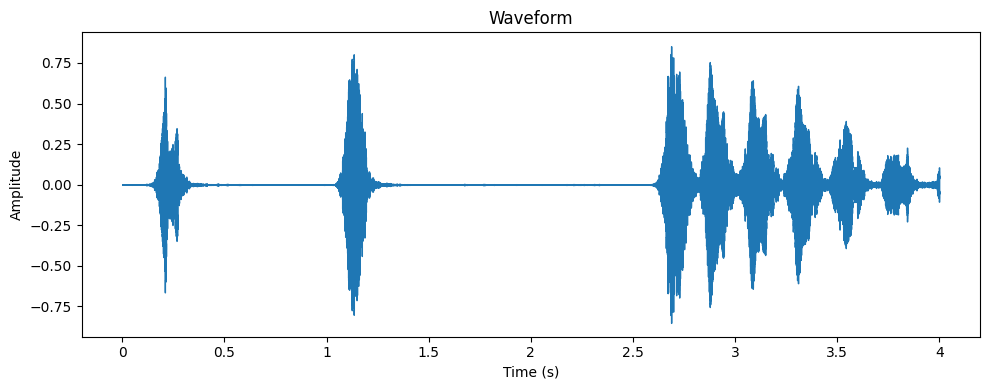

In [21]:
def display_waveform(audio_file, sr=44100):
    """
    Generates and displays the waveform of the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the waveform
display_waveform(input_audio_path)

This plot visually represents the audio signal's amplitude over time of a **dog bark**. It shows the raw audio signal in the time domain, with the horizontal axis representing time (in seconds) and the vertical axis representing the amplitude (intensity) of the sound at each point in time.

This plot is useful for understanding the overall structure and duration of the audio, as well as identifying silent or loud regions, transients, or periodic patterns. However, it does not provide detailed information about the frequency content of the audio, which is captured by other features like **spectrograms** or **MFCCs**.


##### Mel Spectogram

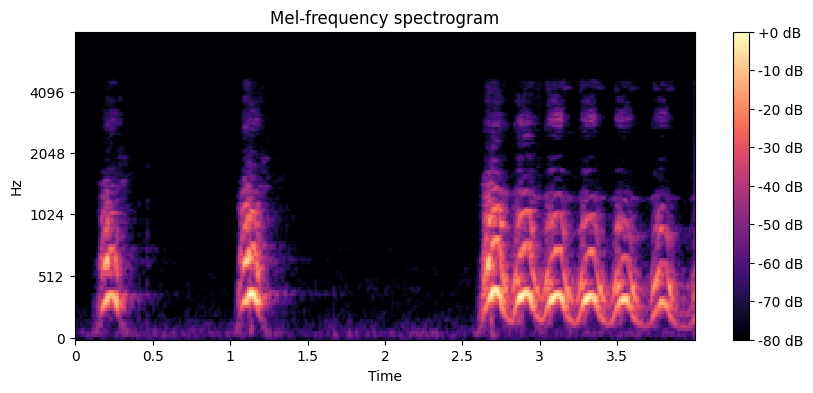

In [22]:
def display_spectrogram(audio_file, sr=44100, fmax=8000):
    """
    Generates and displays a mel-frequency spectrogram for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        fmax (int): Maximum frequency for the mel-frequency spectrogram (default: 8000).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)
    
    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

    # Display the image in the notebook
    plt.show()

# Input audio path
input_audio_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Generate and display the spectrogram
display_spectrogram(input_audio_path)


This shows how the energy of audio signals is distributed over frequency and time (as explained above). 

The bright areas indicate **higher energy** concentrated at specific frequencies, which is characteristic of a dog bark. 

The pattern reveals distinct intervals with bursts of energy and repeating harmonic structures, reflecting the short, sharp, and periodic nature of a typical bark. The onsets and decays visible in the spectrogram align with the rhythmic and energetic nature of dog vocalizations.

##### MFCCs

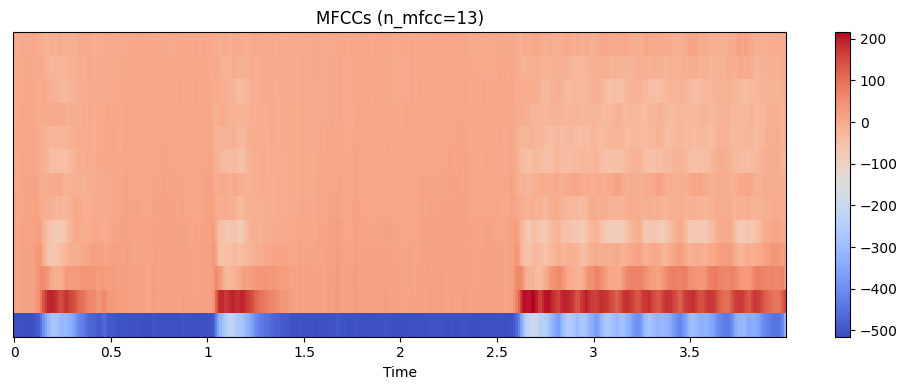

In [23]:
def display_mfcc(audio_file, sr=44100, n_mfcc=13):
    """
    Generates and displays the MFCCs for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        n_mfcc (int): Number of MFCCs to extract (default: 13).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title(f'MFCCs (n_mfcc={n_mfcc})')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Display the MFCCs
display_mfcc(input_audio_path)

This one displays the first 13 Mel-frequency cepstral coefficients (MFCCs) extracted from the audio, which represent the **spectral characteristics** of the sound over time. These coefficients capture key features of the audio's **timbre and texture**, particularly reflecting the overall shape of the sound's frequency spectrum. The horizontal axis represents time, while the vertical axis corresponds to the 13 MFCCs. Since only the first 13 MFCCs are extracted, the plot focuses on the most significant features of the audio signal, which are crucial for tasks like speech recognition and audio classification.

### Cleaning the csvs <a name="cleaning"></a>
[[go back to the topic]](#data-cleaning)

In this section, we will perform data cleaning. This process will include the following steps:

- Check for Missing Values
- Check if there are any columns with object type
- Check for Duplicates
- Validate Column Data Types
- Normalization
- Label Encoding or One-Hot Encoding (dps vemos isto)

##### Missing values

In [29]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f"  - Missing values detected:\n{missing_values[missing_values > 0]}")
    else:
        print("  - No missing values detected.")


##### Columns with object type

In [30]:
def check_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    if object_columns.any():
        print(f"  - Columns with object data type: {object_columns.tolist()}")
    else:
        print("  - No columns with object data type detected.")


##### Duplicates

In [31]:
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  - {duplicates} duplicate rows found.")
        df = df.drop_duplicates()  # Drop duplicates
    else:
        print("  - No duplicate rows detected.")
    return df  # Return the dataframe after dropping duplicates (if any)


##### Column Data Types

In [32]:
def validate_column_data_types(df):
    column_data_types = df.dtypes
    print(f"  - Column data types:\n{column_data_types}")


##### Normalization

In [34]:
def normalize_data(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        scaler = MinMaxScaler()
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        print(f"  - Normalized numeric columns: {numeric_columns.tolist()}")
    else:
        print("  - No numeric columns found for normalization.")
    return df  # Return the dataframe after normalization


##### Putting it All Together

In [37]:
# Iterate through each dataset and apply the data cleaning functions --> FAZEMOS MIN-MAX SCALER OU StandardScaler ???
for i, df in enumerate(datasets, 1):
    print(f"Data cleaning for dataset {i}:")
    
    # 1. Check for missing values
    check_missing_values(df)
    
    # 2. Check if there are any columns with object type (non-numeric columns)
    check_object_columns(df)
    
    # 3. Check for duplicates and drop them
    df = check_duplicates(df)
    
    # 4. Validate column data types
    validate_column_data_types(df)
    
    # 5. Normalization of numeric columns
    #df = normalize_data(df)
    
    print("\n" + "-"*50 + "\n")


Data cleaning for dataset 1:
  - No missing values detected.
  - Columns with object data type: ['fourier_tempogram', 'Label']
  - No duplicate rows detected.
  - Column data types:
chroma_stft          float64
chroma_cqt           float64
chroma_cens          float64
melspectogram        float64
rms                  float64
centroid             float64
bandwidth            float64
contrast             float64
flatness             float64
rolloff              float64
crossing_rate        float64
tempogram            float64
fourier_tempogram     object
mcffs_1              float64
mcffs_2              float64
mcffs_3              float64
mcffs_4              float64
mcffs_5              float64
mcffs_6              float64
mcffs_7              float64
mcffs_8              float64
mcffs_9              float64
mcffs_10             float64
mcffs_11             float64
mcffs_12             float64
mcffs_13             float64
mcffs_14             float64
mcffs_15             float64
mcffs_